In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
def abline(slope, intercept, color = None):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = color)

## Vector-bandit
Assume there are $U$ users and $I$ items. Each are represented by a $d$ dimensional vector. All the vectors are normalized.

Given that you show item i to user u, the probability that u will click is $X^T_u Y_i$.

We implement the environment 

In [373]:
class ClickProbEnv():
    def __init__(self, d = 10, U = 10, I = 10, batch_size = 4):
        self.batch_size = batch_size
        self.U = U
        self.I = I
        self.d = d
        X = torch.rand(U,d) - 0.5
        self.X = X/X.norm(2,1,keepdim=True)
        Y = torch.rand(I,d) - 0.5
        self.Y = Y/Y.norm(2,1,keepdim=True)
        
    def click_prob(self, u, i):
        return torch.max(torch.tensor(0.0),((self.X[u,]*self.Y[i,]).sum(dim= 1, keepdim=True)))
    
    def step(self, u, i):
        p = self.click_prob(u,i)
        return (self.click_prob(u,i) >= torch.rand((len(u),1))).float()
    
    def get_users(self, bs = None):
        if bs is None:
            bs = self.batch_size
        return torch.randint(self.U, (bs,)).long()
#env = ClickProbEnv(d = 100)    

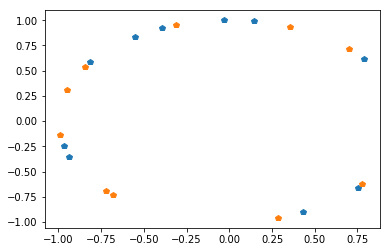

In [374]:
env = ClickProbEnv(d = 2)
plt.plot(env.X.numpy()[:,0], env.X.numpy()[:,1], "p")
plt.plot(env.Y.numpy()[:,0], env.Y.numpy()[:,1], "p")

# Case 1: No knowledge of user

## Simple greedy algorithm

If you execute each action many times they will converge

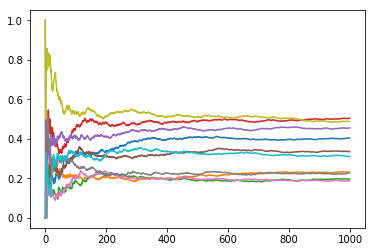

In [375]:
steps = 1000
for i in range(10):
    reward = torch.cat([env.step(env.get_users(bs=1), i) for _ in range(steps)])
    phat = reward.cumsum(0).view(-1)/torch.arange(1,steps+1).float()
    plt.plot(phat.numpy())

###  Finding average click probabilities per action
A simple evaluation to find the average reward per action:

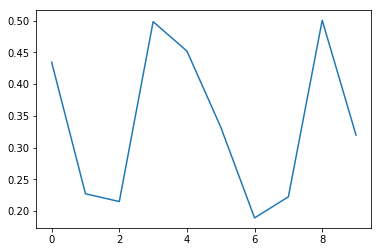

In [380]:
best_actions = [np.mean([env.click_prob(env.get_users(1),item) for _ in range(10000)]) for item in range(10)]
plt.plot(best_actions)

## Epsilon greedy
we let the bernoulli-agent do an epsilon greedy search with different epsilon parameters

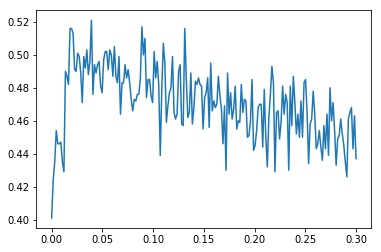

In [377]:
rewards, actions = np.ones(env.I)*0.0, np.ones(env.I)*1
steps = 1000
eps = np.linspace(0,0.3,200)
avg_reward = np.zeros(len(eps))
for t, ep in enumerate(eps):
    r = np.zeros(steps)
    for i in range(steps):
        # sample a user (but dont show it to the algorithm)
        user = env.get_users(bs=1)

        # Select action:
        if np.random.rand() > ep:
            action = np.argmax(rewards/actions)
        else:
            action = np.random.randint(env.I)
        r[i] = env.step(user, action)


        # update algorithm
        rewards[action] += r[i]
        actions[action] += 1

    #print("epsilon: {}, Avg rewards: {}".format(ep, r.sum()/steps))
    avg_reward[t] = r.sum()/steps
phat = r.cumsum(0)/torch.arange(1,steps+1).float()
plt.plot(eps, avg_reward)


#### Performance of best epsilon

In [511]:
steps = 100
ep = 0.05
avg_reward = np.zeros(100)
for t, _ in enumerate(avg_reward):
    rewards, actions = np.ones(env.I)*0.0, np.ones(env.I)*1
    r = np.zeros(steps)
    for i in range(steps):
        # sample a user (but dont show it to the algorithm)
        user = env.get_users(bs=1)

        # Select action:
        if np.random.rand() > ep:
            action = np.argmax(rewards/actions)
        else:
            action = np.random.randint(env.I)
        r[i] = env.step(user, action)


        # update algorithm
        rewards[action] += r[i]
        actions[action] += 1

    #print("epsilon: {}, Avg rewards: {}".format(ep, r.sum()/steps))
    avg_reward[t] = r.sum()/steps


0.42879999999999996
0.05530424938465398


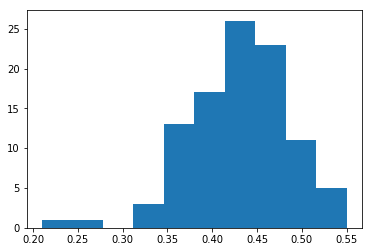

In [512]:
print(avg_reward.mean())
print(avg_reward.std())
_ = plt.hist(avg_reward)

### Greedy Beta Bernoulli Bandit

In [442]:
import pyro

In [509]:
steps = 100
avg_reward = np.zeros(100)
for t, _ in enumerate(avg_reward):
    alpha, beta = torch.ones(env.I), torch.ones(env.I)
    r = torch.zeros(steps)
    for i in range(steps):
        # sample a user (but dont show it to the algorithm)
        user = env.get_users(bs=1)
        
        # Select action
        action_values = alpha/(alpha+beta)
        action = action_values.argmax()
        r[i] = env.step(user, action)

        # update algorithm
        alpha[action] += r[i]
        beta[action] += 1-r[i]

    #print("epsilon: {}, Avg rewards: {}".format(ep, r.sum()/steps))
    avg_reward[t] = r.sum()/steps

0.43959999799728394
0.060115220495177785


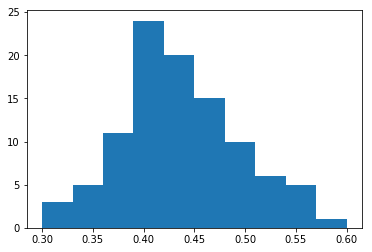

In [510]:
print(avg_reward.mean())
print(avg_reward.std())
_ =plt.hist(avg_reward)

### Thompson Sampling in Beta Bernoulli

In [513]:
steps = 100
avg_reward = np.zeros(100)
for t, _ in enumerate(avg_reward):
    alpha, beta = torch.ones(env.I), torch.ones(env.I)
    r = torch.zeros(steps)
    for i in range(steps):
        # sample a user (but dont show it to the algorithm)
        user = env.get_users(bs=1)
        
        # Select action
        action_values = torch.tensor([pyro.distributions.Beta(alpha[i], beta[i]).sample() for i in range(env.I)])
        action = action_values.argmax()
        r[i] = env.step(user, action)

        # update algorithm
        alpha[action] += r[i]
        beta[action] += 1-r[i]

    avg_reward[t] = r.sum()/steps

0.39139999970793726
0.05728908885816376


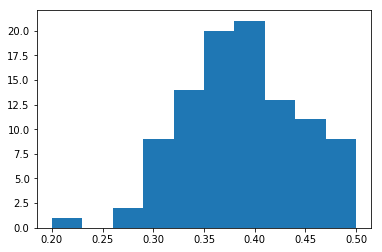

In [514]:
print(avg_reward.mean())
print(avg_reward.std())
_ =plt.hist(avg_reward)